# Imports

In [3]:
import pickle
import os
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import eli5
import shap
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [11]:
model_df = pd.read_csv('01_mtb_model_df_out.csv', usecols=range(1, model_df.shape[1]))

In [12]:
model_df.head(1)

,date_clean,trail,AWND,PRCP,TMAX,PRCP_2d,TMAX_2d,PRCP_3d,TMAX_3d,PRCP_7d,TMAX_7d,target
0,2020-01-01,Milford Trails,9.84,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Build Model
- 1 is Open, 0 is Closed

<Figure size 800x350 with 0 Axes>

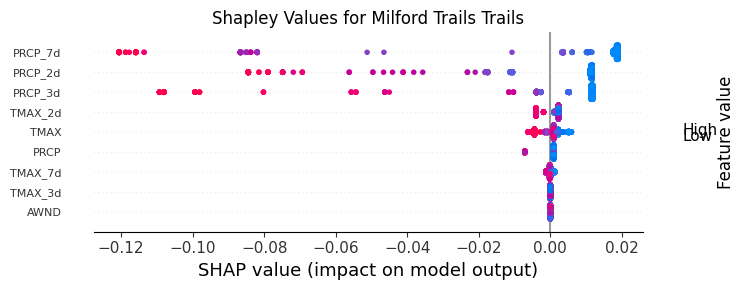

<Figure size 800x350 with 0 Axes>

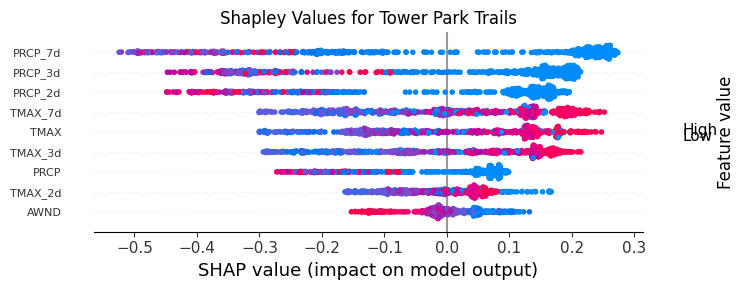

<Figure size 800x350 with 0 Axes>

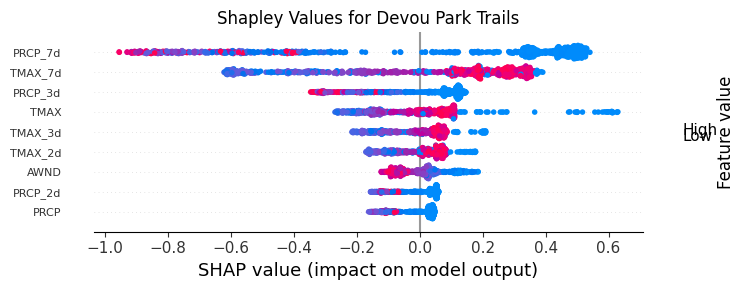

<Figure size 800x350 with 0 Axes>

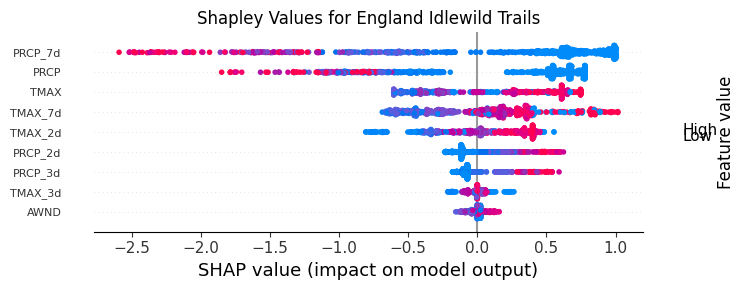

<Figure size 800x350 with 0 Axes>

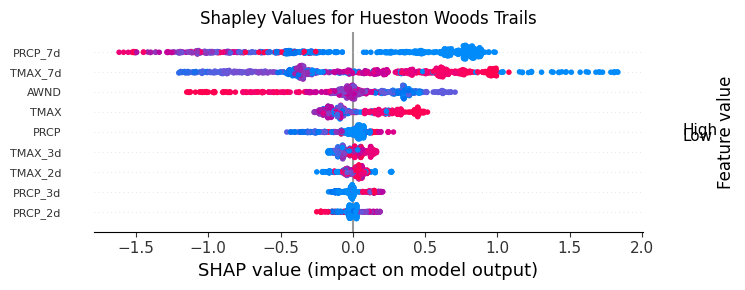

<Figure size 800x350 with 0 Axes>

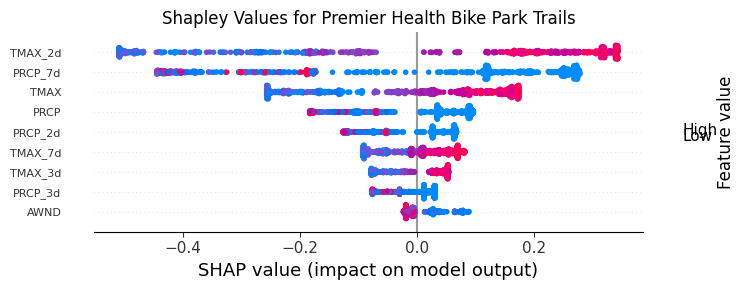

<Figure size 800x350 with 0 Axes>

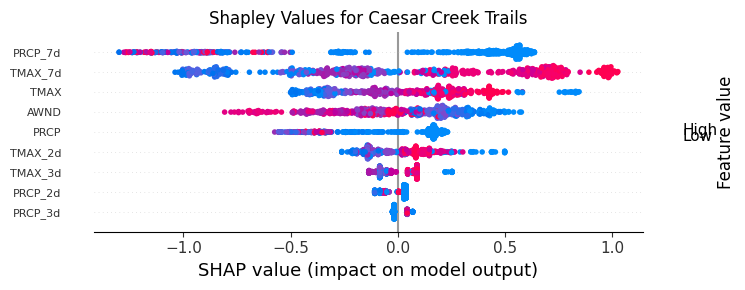

<Figure size 800x350 with 0 Axes>

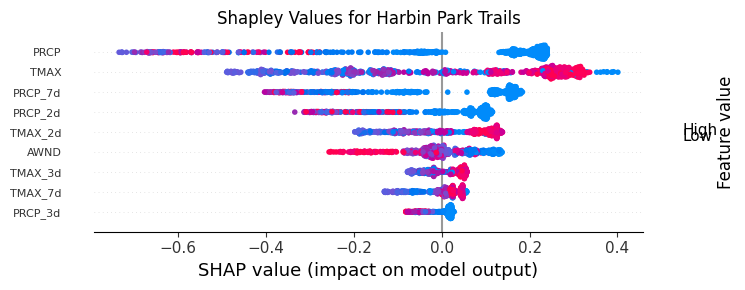

<Figure size 800x350 with 0 Axes>

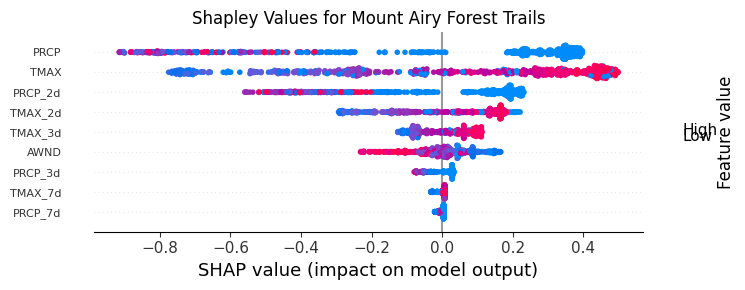

<Figure size 800x350 with 0 Axes>

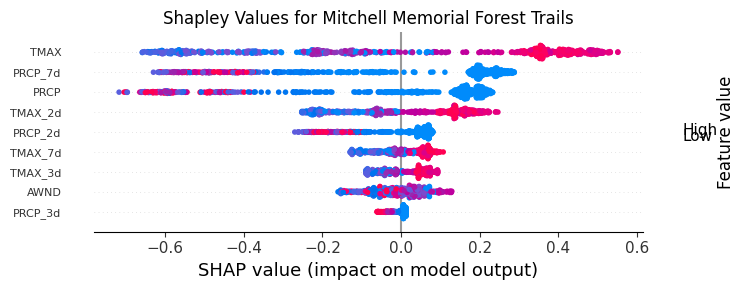

<Figure size 800x350 with 0 Axes>

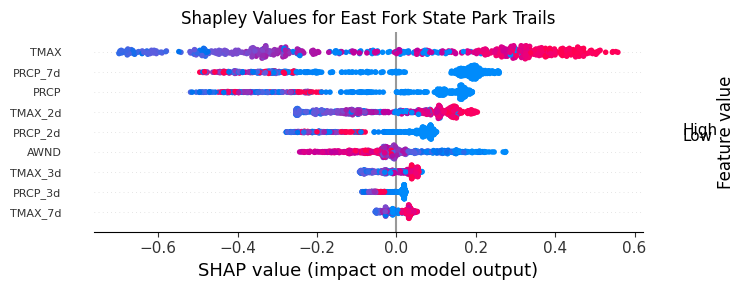

<Figure size 800x350 with 0 Axes>

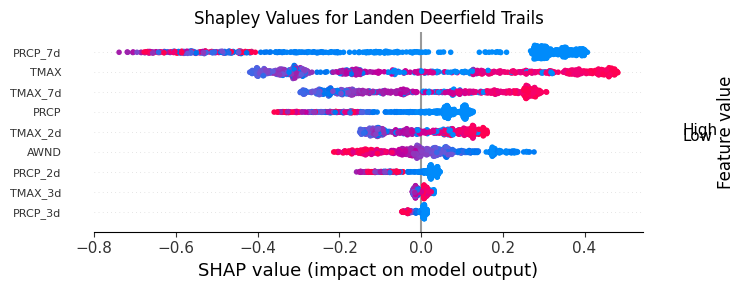

In [13]:
from sklearn.model_selection import StratifiedKFold

model_df_input = model_df.copy()
unique_trails = model_df_input["trail"].unique()

# Drop Columns Not Needed for Modeling
if 'date_clean' in model_df_input.columns:
    model_df_input = model_df_input.drop(columns=['date_clean'])

# Define features and target
features = model_df_input.drop('target', axis=1)
target = model_df_input['target']

# Perform a train-test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

# Further split the training set into a training and validation set
features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, test_size=0.25, random_state=42)

# Dictionary to hold models for each trail
trail_models = {}

# Initialize lists to store data for final dataframes
all_feature_importances = []
shap_values_all = []
model_evaluations = []


# New Param Grid 7/21
param_dist = {
    'n_estimators': range(50, 200, 50),
    'max_depth': range(2, 6),
    'min_child_weight': range(1, 8),
    'gamma': [i/10.0 for i in range(0, 10)],
    'subsample': [i/10.0 for i in range(3, 9)],
    'colsample_bytree': [i/10.0 for i in range(7, 11)],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [0, 1, 10],
    'reg_alpha': [0, 1, 10]
}


# Train and select the best model for each trail
for trail in unique_trails:
    # Prepare train and validation data for the specific trail
    trail_mask_train = features_train["trail"] == trail
    trail_X_train = features_train.loc[trail_mask_train, :].drop(columns=['trail'])
    trail_y_train = target_train.loc[trail_mask_train]

    trail_mask_val = features_val["trail"] == trail
    trail_X_val = features_val.loc[trail_mask_val, :].drop(columns=['trail'])
    trail_y_val = target_val.loc[trail_mask_val]

    # Create a XGBClassifier object
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create the RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=xgb,
                                       param_distributions=param_dist,
                                    #    n_iter=250, #  Number of parameter settings that are sampled
                                       n_iter=5,   
                                       scoring='roc_auc',  # You can change this to the metric you want to optimize
                                    #    cv=5,  # Cross-validation splitting strategy
                                       cv=skf,
                                       verbose=0, 
                                       random_state=42)

    # Perform the randomized search
    random_search.fit(trail_X_train, trail_y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Save the model
    trail_models[trail] = best_model

    # Get predictions for the validation set
    predictions_val = best_model.predict_proba(trail_X_val)[:, 1]

    # Calculate the ROC AUC of the predictions
    roc_auc_val = roc_auc_score(trail_y_val, predictions_val)
    
    # Save the ROC AUC score and the trail in the model evaluations
    model_evaluations.append({
        'trail': trail,
        'roc_auc_val': roc_auc_val,
    })

    # Get feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_,
                                       index=trail_X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    all_feature_importances.append(feature_importances)

    # Use SHAP to explain the model's predictions
    plt.figure(figsize=(8, 3.5))
    
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(trail_X_train)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.set_title(f"Shapley Values for {trail} Trails")
    shap.summary_plot(shap_values, trail_X_train, plot_size=None, show=False)
    plt.tick_params(axis='y', which='major', labelsize=8)  # Set y-tick label size
    plt.tight_layout()
    plt.show()

    shap_values_df = pd.DataFrame(shap_values, columns=trail_X_train.columns)
    shap_values_all.append(shap_values_df)

# Create final dataframes
feature_importances_df = pd.concat(all_feature_importances, axis=0, ignore_index=True)
shap_values_df_all = pd.concat(shap_values_all, axis=0, ignore_index=True)
model_evaluations_df = pd.DataFrame(model_evaluations)

# Initialize a list to store test set evaluations
test_evaluations = []

# Evaluate each model on the test set
for trail, model in trail_models.items():
    # Prepare test data for the specific trail
    trail_mask_test = features_test["trail"] == trail
    trail_X_test = features_test.loc[trail_mask_test, :].drop(columns=['trail'])
    trail_y_test = target_test.loc[trail_mask_test]

    # Check if there are test samples for the trail
    if len(trail_y_test) == 0:
        print(f"No test samples for trail: {trail}")
        continue
    
    # Get predictions for the test set
    predictions_test = model.predict_proba(trail_X_test)[:, 1]

    # Calculate the ROC AUC of the predictions
    roc_auc_test = roc_auc_score(trail_y_test, predictions_test)

    test_evaluations.append({
        'trail': trail,
        'roc_auc_test': roc_auc_test,
    })

# Create final dataframe
test_evaluations_df = pd.DataFrame(test_evaluations)

In [14]:
feature_importances_df.head(1)


,importance
0,0.18772


In [15]:
shap_values_df_all.head(1)


,AWND,PRCP,TMAX,PRCP_2d,TMAX_2d,PRCP_3d,TMAX_3d,PRCP_7d,TMAX_7d
0,0.0,0.000929,0.000945,0.011354,-0.004007,0.011839,0.0,0.018892,-0.000173


In [16]:
model_evaluations_df.merge(test_evaluations_df, how = 'inner', on = 'trail').sort_values('roc_auc_val', ascending=False)

,trail,roc_auc_val,roc_auc_test
3,England Idlewild,0.867982,0.792002
10,East Fork State Park,0.846917,0.789488
2,Devou Park,0.831182,0.874873
5,Premier Health Bike Park,0.828418,0.808516
1,Tower Park,0.823476,0.860527
7,Harbin Park,0.819991,0.787729
8,Mount Airy Forest,0.817465,0.873819
6,Caesar Creek,0.790987,0.789132
9,Mitchell Memorial Forest,0.788239,0.829678
4,Hueston Woods,0.772360,0.785872


In [17]:
import joblib

# Save the dictionary of models
joblib.dump(trail_models, '02_trail_models.joblib')

['02_trail_models.joblib']